# Using Features From Pre-Trained Network For Training

In [117]:
import os
import re
import random
import io
import urllib.request
import functools as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL

from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

from keras.applications import VGG16

from IPython.display import display, HTML

In [68]:
data_dir  = os.path.join("var", "data")
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")
model_dir = os.path.join("var", "model")

os.makedirs(model_dir, exist_ok=True)

## Load the Pre Trained Model

In [2]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 9s 0us/step


In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Extract Features

In [77]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

In [79]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [82]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Train the Model on Extracted Features

In [80]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(
    optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

In [83]:
history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 7s 3ms/step - loss: 0.6055 - acc: 0.6625 - val_loss: 0.4646 - val_acc: 0.8000
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4401 - acc: 0.7975 - val_loss: 0.3881 - val_acc: 0.8280
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3643 - acc: 0.8465 - val_loss: 0.3681 - val_acc: 0.8220
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3348 - acc: 0.8580 - val_loss: 0.3351 - val_acc: 0.8490
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2909 - acc: 0.8770 - val_loss: 0.3205 - val_acc: 0.8670
Epoch 6/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2715 - acc: 0.8910 - val_loss: 0.3069 - val_acc: 0.8590
Epoch 7/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2615 - acc: 0.9000 - val_loss: 0.2949 - val_acc: 0.8780
Epoch 8/30
200

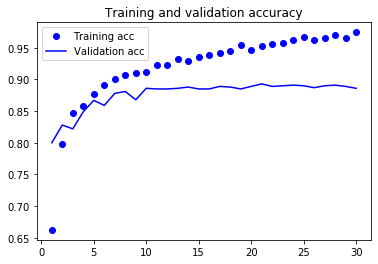

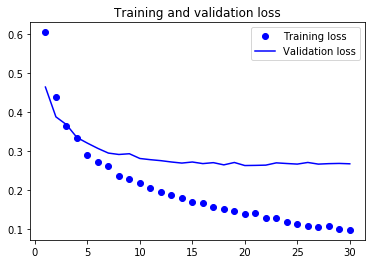

In [86]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Try Out Some Images

In [ ]:
def get_image(image_url):
    with urllib.request.urlopen(image_url) as fh:
        image_data = fh.read()
    return PIL.Image.open(io.BytesIO(image_data))

def image_preprocess(img):
    return img.convert('RGB').resize((150, 150))

def image_to_model_array(img):
    img_arr = image.img_to_array(img)
    img_arr = img_arr.reshape((1,) + img_arr.shape)
    return img_arr

[1.]
dog


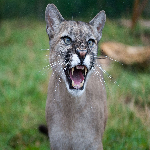

[1.]
dog


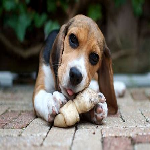

[0.]
cat


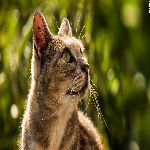

[0.]
cat


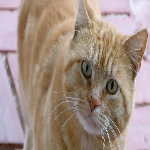

[0.]
cat


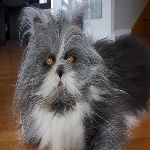

[0.]
cat


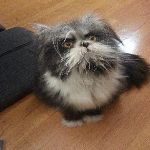

[1.]
dog


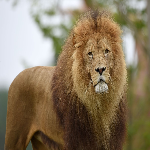

[0.]
cat


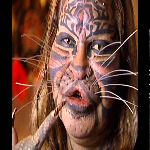

[1.]
dog


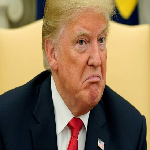

[1.]
dog


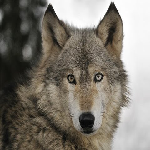

[1.]
dog


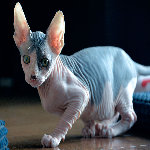

In [129]:
urls = [
    "https://static.independent.co.uk/s3fs-public/thumbnails/image/2018/05/20/15/cougar.jpg",
    "https://www.bing.com/th/id/OIP.VaQHItXswINeZZm7DsX3jAHaE6?w=299&h=195&c=7&o=5&dpr=1.5&pid=1.7",
    "https://cdn.cnn.com/cnnnext/dam/assets/180830100926-02-new-zealand-cat-stock-super-tease.jpg",
    "https://i.ytimg.com/vi/du2begoIXNc/maxresdefault.jpg",
    "https://s.abcnews.com/images/Lifestyle/HT-cat-dog-01-jef-161110_16x9_992.jpg",
    "https://pbs.twimg.com/media/CwcIlk_UcAAFDhV.jpg",
    "https://tribktla.files.wordpress.com/2018/12/GettyImages-800103882.jpg?quality=85&strip=all&w=1200",
    "https://i.ytimg.com/vi/PvhSYBAj3UE/maxresdefault.jpg",
    "https://i1.wp.com/media.boingboing.net/wp-content/uploads/2019/02/trump.jpeg?fit=640%2C420&ssl=1",
    "https://i.ytimg.com/vi/LKeBIMgACxU/hqdefault.jpg",
    "https://peopledotcom.files.wordpress.com/2016/12/kitten.jpg",
]

def get_category(img):
    r = conv_base.predict(image_to_model_array(img))
    x = r.reshape((1, F.reduce(lambda a, b: a * b, r.shape[1:])))
    p = model.predict_proba(x)[0][0]
    return "dog" if p >= 0.5 else "cat"

for url in urls:
    img = get_image(url)
    img = image_preprocess(img)
    print(get_category(img))
    display(img)